# Обнаружение нарушений в структуре

В тесте на ускорение нажатий требовалось многократно повторить одну и ту же комбинацию нажатий на две разных кнопки.

In [1]:
%pylab inline

import re
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
u = 'd/m__178.155.4.92__3219165950000190320.tsv'
M = pd.read_table(u)
M.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       1041 non-null   float64
 1   v       1041 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 16.4 KB


Самыми сложными были 5-й и 6-й этапы теста, где на 3 нажатия одной рукой приходилось 1 нажатие другой.

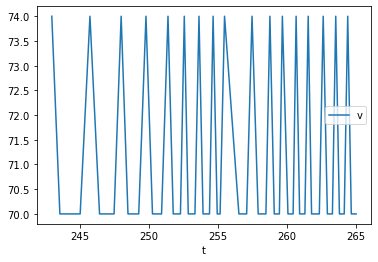

In [4]:
coab, coad = 1005, 13
tab = M.t[M.v==coab].iloc[0]
tad = M.t[(M.t>tab) & (M.v==coad)].iloc[0]
R = M[(M.t>=tab)&(M.t<tad)].copy()
# оставим только нажатия клавиши - код < 100
R = R[R.v.abs()<100]
R = R[R.v > 0]
R.plot('t','v');

По заданию должно быть только два типа нажатий: на клавиши с кодами 70 и 74 (F и J). 
Последовательность кодов можно преобразовать в строку. Со строками можно производить операции поиска.

In [5]:
rr = R.v[R.v.isin([70,74])].values

s=''.join(map(chr, rr))
seq = s.lower()
seq

'jfffjfffjfffjfffjfffjfffjfffjffjfffjfffjfffjfffjfffjfffjfffjfffjfff'

Самый простой подход - пройти вдоль строки и найти все места, где она совпадает с образцом.

In [6]:
pattern = 'jfff'
ii=[]
i = 0
while i < len(seq)-len(pattern)+1:
    i = seq.find(pattern, i)
    if i<0:
        break
    ii.append(i)
    i += len(pattern)

ii = asarray(ii)
ii

array([ 0,  4,  8, 12, 16, 20, 24, 31, 35, 39, 43, 47, 51, 55, 59, 63])

Можно записать цикл в одну строку.

In [7]:
ii = array([m.start() for m in re.finditer(pattern, seq)])
ii

array([ 0,  4,  8, 12, 16, 20, 24, 31, 35, 39, 43, 47, 51, 55, 59, 63])

Совпадения с образцом должны происходить строго через каждые 4 символа.

Ошибки можно установить по тем местам, где это не так.
Для этого найдем места, где разница между обнаруженными "правильными" индексами не равна длине паттерна и сдвинемся на длину паттерна.


In [8]:
errpos = ii[where(diff(ii)!=len(pattern))[0]] + len(pattern)
errpos

array([28])

In [9]:
tterr = R.t.iloc[errpos]
tterr

720    254.654
Name: t, dtype: float64

Посмотрим исходные маркеры в том месте, где случилась ошибка.

In [10]:
i = R.index[errpos[0]]
M[i:i+12]

,t,v
720,254.654,74
721,254.768,-74
722,254.954,70
723,255.053,-70
724,255.163,70
725,255.258,-70
726,255.485,74
727,255.569,-74
728,256.527,70
729,256.647,-70


> В чем суть обнаруженной ошибки? Сколько было нажатий левой рукой между нажатиями правой?

Знание мест, где начинались "правильные" паттерны, позволит нам выделить четыре типа реакций и проанализировать их отдельно. 
Например, можно изобразить их разными цветами на рисунке.
Для подписей мы сделаем последовательность с обозначением рук.

In [11]:
haha = where(asarray(list(pattern))=='j', 'R', 'L')
haha

array(['R', 'L', 'L', 'L'], dtype='<U1')

In [12]:
[ii.reshape(-1,1) + arange(len(pattern))]

[array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27],
        [31, 32, 33, 34],
        [35, 36, 37, 38],
        [39, 40, 41, 42],
        [43, 44, 45, 46],
        [47, 48, 49, 50],
        [51, 52, 53, 54],
        [55, 56, 57, 58],
        [59, 60, 61, 62],
        [63, 64, 65, 66]])]

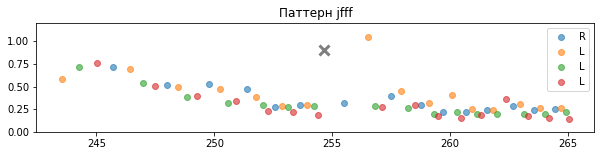

In [13]:
R['iri'] = R.t.diff()

I = ii.reshape(-1,1) + arange(len(pattern))
T = R.t.values[I]
V = R.iri.values[I]

plt.figure(figsize=(10,2))

plot(T, V, 'o', alpha=.6); legend(haha);

yerr = .9
plot(tterr, yerr*ones_like(tterr), 'x', ms=10, mew=3, color='k', alpha=.5)
ylim(0, 1.2);
title('Паттерн {}'.format(pattern));

Можно заметить, что интервалы между нажатиями систематически варьировали в зависимости от позиции в паттерне.

> Попробуйте выбрать все необходимые команды для построения такого же графика для 6-го этапа.
При этом удалите все избыточные команды, а необходимые поместите в одну ячейку.

## Последовательность чисел

С последовательностями можно работать напрямую - в виде чисел.

Для наглядности преобразуем их в нули и единицы. Это один из способов стандартизации чисел - отнять минимум и разделить на размах.

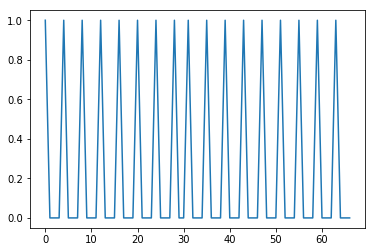

In [15]:
rr = (rr - rr.min())/(rr.max()-rr.min())
plot(rr);

Из чисел, состоящих из одного символа, также можно сделать строки. 

In [16]:
seq = ''.join(rr.astype(int).astype(str))
seq

'1000100010001000100010001000100100010001000100010001000100010001000'

При работе с числами совпадение последовательностей соответствует корреляции.

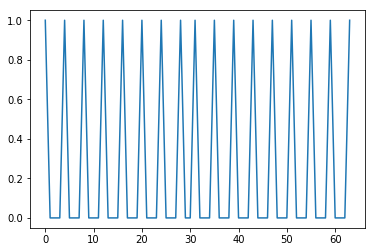

In [17]:
patt = array([1,0,0,0])
c = correlate(rr, patt)
plot(c);

In [18]:
where(c==c.max())[0]

array([ 0,  4,  8, 12, 16, 20, 24, 28, 31, 35, 39, 43, 47, 51, 55, 59, 63],
      dtype=int64)

> Сравните полученные индексы, в чем разница с теми, что мы получили поиском подстроки?

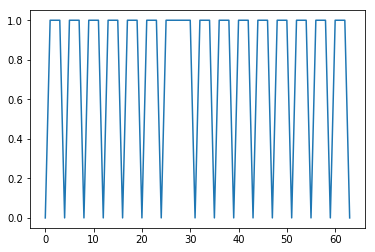

In [19]:
c = correlate(rr, 1-patt)
plot(c);

In [21]:
where(c==c.min())[0]

array([ 0,  4,  8, 12, 16, 20, 24, 31, 35, 39, 43, 47, 51, 55, 59, 63],
      dtype=int64)

> А теперь индексы различаются?

Корреляционные методы работают и при частичном совпадении "подъемов" и "спусков". Например, можно посчитать две функции кросс-корреляции с обратными паттернами и выбрать тот, при котором события разделены.

Чтобы найти точное соответствие подобно тому как мы искали подстроки, можно составить матрицу из одной и той же последовательности, но со сдвигом. Затем найти строки, совпадающие с паттерном.

In [22]:
Seq = np.vstack(np.roll(rr, shift) for shift in -np.arange(len(patt))).T

where(all(Seq == patt, axis=1))[0]

array([ 0,  4,  8, 12, 16, 20, 24, 31, 35, 39, 43, 47, 51, 55, 59, 63],
      dtype=int64)

Таким образом, при работе с последовательностями большинство операций производится с индексами - позициями тех или иных событий.
Расстояние между событиями - разница между индексами.

В рассмотренном нами случае каждое событие имело также отметку времени. Поэтому наряду с разницей в индексах можно рассчитать интервалы в секундах.

Совместное использование двух подходов дает возможность обнаруживать пропуски событий, например, когда нажатие должно было случиться, но было таким быстрым и легким, что электромеханический контакт клавиши не сработал.